In [1]:
import pandas as pd
import seaborn as sns

In [2]:
import sys
sys.path.append("..")

In [3]:
from src import disjoint_cv

In [4]:
label_df =pd.read_csv('../data/input/labeled_ddi_DBv5.0.3.csv')

In [5]:
ddi5_df = pd.read_csv('../data/input/ddi_v5.txt', sep='\t')

In [6]:
ddi4_df = pd.read_csv('../data/input/ddi_v4.txt', sep='\t')

In [7]:
ddi4_df.head()

,Drug1,Drug2
0,DB00005,DB00026
1,DB00026,DB00005
2,DB00005,DB00065
3,DB00065,DB00005
4,DB00005,DB00072


In [8]:
def swap(drug1, drug2):
    if drug1 < drug2:
        return drug1,drug2
    else:
        return drug2,drug1

In [9]:
def getPositiveLabeledPairs(ddiset_df, label_df):
    pairs = []
    classes = []

    ddiKnown = set(ddiset_df.apply(lambda row: swap(row[0],row[1]), axis=1))
    ddiLabel = set(label_df.apply(lambda row: swap(row[0],row[1]), axis=1))
    
    all_positives = ddiKnown.intersection(ddiLabel)
    commonDrugs = set([ d1 for (d1,d2) in all_positives])
    print("Postive size: %d" % len(all_positives))
    print ('Drugs',len(commonDrugs))
    return commonDrugs, all_positives

In [10]:
common_drugs_db5, all_positives_db5 =getPositiveLabeledPairs(ddi5_df, label_df)

Postive size: 175866
Drugs 1528


In [11]:
from scipy.stats import chisquare
def chisquare_prediction(obs, exp):
    a= obs.value_counts()
    b= exp.value_counts()
    a.name = 'obs'
    b.name ='exp'
    a= a[a>5]
    b= b[b>5]
    frequency_dist = pd.concat([a, b], axis=1).dropna()
    return chisquare(f_obs= frequency_dist.obs,   # Array of observed counts
                f_exp= frequency_dist.exp)

In [14]:
def plot_distribution_k_fold(commonDrugs, all_positives, n_fold):
    #train_drugs, test_drugs, train_positives, test_positives_drugwise, test_positives_pairwise  = disjoint_cv.drugwise_k_fold_cross(commonDrugs, all_positives, n_fold)
        #c1_results = pd.DataFrame()
    
    drugwise_results = pd.DataFrame()
    pairwise_results = pd.DataFrame()
    train_results = pd.DataFrame()
    
    distribution = pd.DataFrame()
    
    drug_k_fold = disjoint_cv.drugwise_k_fold_cross(commonDrugs, all_positives, n_fold)
    for i,(fold_data) in enumerate(drug_k_fold):
        print ('fold',i)
        i, train_drugs, test_drugs, train_positives, test_positives_drugwise, test_positives_pairwise = fold_data
        print ("train drugs",len(train_drugs),"test drugs",len(test_drugs))
        
        train_positives_df = pd.DataFrame(train_positives, columns=['Drug1','Drug2'])
        train_positives_df = train_positives_df.merge(label_df, how='left', on=['Drug1','Drug2'])
        train_results = train_results.append(train_positives_df, ignore_index=True)
        
        test_drugwise_df = pd.DataFrame(test_positives_drugwise, columns=['Drug1','Drug2'])
        test_drugwise_df = test_drugwise_df.merge(label_df, how='left', on=['Drug1','Drug2'])
        drugwise_results= drugwise_results.append(test_drugwise_df,ignore_index=True)
        
        test_pairwise_df = pd.DataFrame(test_positives_pairwise, columns=['Drug1','Drug2'])
        test_pairwise_df = test_pairwise_df.merge(label_df, how='left', on=['Drug1','Drug2'])
        pairwise_results = pairwise_results.append(test_pairwise_df, ignore_index=True)
        
        chisqure_dw = chisquare_prediction(obs=test_drugwise_df.Label, exp= train_positives_df.Label)
        chisquare_pw = chisquare_prediction(obs=test_pairwise_df.Label, exp= train_positives_df.Label)
        print ('Drug-wise Test & Train','Pairwise Test & Train')
        print ('Chisquare-statistic \t p-value  \t Chisquare-statistic  \t p-value' )
        print (chisqure_dw[0],'\t', chisqure_dw[1],'\t', chisquare_pw[0],'\t', chisquare_pw[1] )

        
   
        a = test_drugwise_df.Label.value_counts()
        b = test_pairwise_df.Label.value_counts()
        c = train_positives_df.Label.value_counts()
        a.name = 'Drug-wise test set'
        b.name = 'Pairwise test set'
        c.name = 'Traning set'
        
        frequency_dist = pd.concat([a, b, c], axis=1).fillna(0)
        frequency_dist['fold'] = i
        frequency_dist['label'] = frequency_dist.index

        distribution = distribution.append(frequency_dist, ignore_index=True)
    
    return distribution, train_results, drugwise_results, pairwise_results
    

In [15]:
distribution, train_results, drugwise_results, pairwise_results = plot_distribution_k_fold(common_drugs_db5, all_positives_db5, n_fold=10)

fold 0
train drugs 1368 test drugs 160
Drug-wise Test & Train Pairwise Test & Train
Chisquare-statistic 	 p-value  	 Chisquare-statistic  	 p-value
43292.738750419565 	 0.0 	 63614.47516974767 	 0.0
fold 1
train drugs 1376 test drugs 152
Drug-wise Test & Train Pairwise Test & Train
Chisquare-statistic 	 p-value  	 Chisquare-statistic  	 p-value
46249.79222327203 	 0.0 	 65451.44273081325 	 0.0
fold 2
train drugs 1376 test drugs 152
Drug-wise Test & Train Pairwise Test & Train
Chisquare-statistic 	 p-value  	 Chisquare-statistic  	 p-value
48517.31784981187 	 0.0 	 64449.91741121317 	 0.0
fold 3
train drugs 1376 test drugs 152
Drug-wise Test & Train Pairwise Test & Train
Chisquare-statistic 	 p-value  	 Chisquare-statistic  	 p-value
46736.32085360195 	 0.0 	 65411.43093231979 	 0.0
fold 4
train drugs 1376 test drugs 152
Drug-wise Test & Train Pairwise Test & Train
Chisquare-statistic 	 p-value  	 Chisquare-statistic  	 p-value
41339.19674629833 	 0.0 	 65210.20031906982 	 0.0
fold 5
tr

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


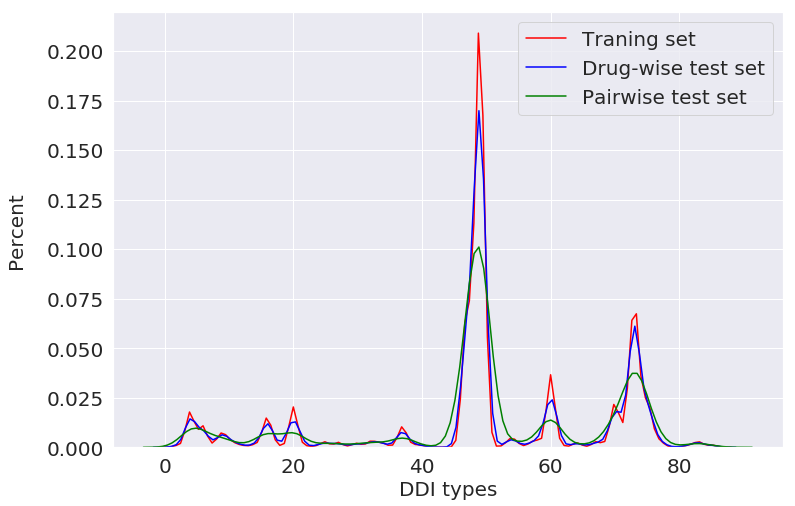

In [16]:

sns.set(rc={'figure.figsize':(12,8),'legend.fontsize': 20.0})
ax = sns.distplot( train_results.Label ,hist =False, norm_hist= True, color="red", label="Traning set")    
ax = sns.distplot( drugwise_results.Label, hist =False,norm_hist= True, color="blue", label="Drug-wise test set")
ax = sns.distplot( pairwise_results.Label, hist =False,norm_hist= True, color="green", label="Pairwise test set")

ax.set_ylabel("Percent",fontsize=20)
ax.set_xlabel("DDI types",fontsize=20)
ax.yaxis.labelpad = 20
ax.tick_params(labelsize=20)
ax.figure.savefig("db5_percent_test_mean_distribution.png")

In [17]:
distribution.head()

,Drug-wise test set,Pairwise test set,Traning set,fold,label
0,0.0,0.0,1.0,9,1.0
1,37.0,0.0,97.0,9,2.0
2,15.0,4.0,13.0,9,3.0
3,273.0,3.0,2473.0,9,4.0
4,25.0,0.0,164.0,9,5.0


In [18]:
dist = distribution.pivot(index='label', columns='fold', values=['Traning set', 'Drug-wise test set', 'Pairwise test set']) 

In [19]:
dist.to_csv('../results/db5_distribution_train_test.csv')

In [20]:
common_drugs_db4, all_positives_db4 =getPositiveLabeledPairs(ddi4_df, label_df)

Postive size: 34583
Drugs 1098


In [21]:
distribution, train_results, drugwise_results, pairwise_results = plot_distribution_k_fold(common_drugs_db4, all_positives_db4, n_fold=10)

fold 0
train drugs 981 test drugs 117
Drug-wise Test & Train Pairwise Test & Train
Chisquare-statistic 	 p-value  	 Chisquare-statistic  	 p-value
8907.246573291328 	 0.0 	 9675.135155157066 	 0.0
fold 1
train drugs 989 test drugs 109
Drug-wise Test & Train Pairwise Test & Train
Chisquare-statistic 	 p-value  	 Chisquare-statistic  	 p-value
8113.633481227052 	 0.0 	 8959.441477633784 	 0.0
fold 2
train drugs 989 test drugs 109
Drug-wise Test & Train Pairwise Test & Train
Chisquare-statistic 	 p-value  	 Chisquare-statistic  	 p-value
7964.946573651519 	 0.0 	 8451.637074154398 	 0.0
fold 3
train drugs 989 test drugs 109
Drug-wise Test & Train Pairwise Test & Train
Chisquare-statistic 	 p-value  	 Chisquare-statistic  	 p-value
8498.563928518699 	 0.0 	 8848.803692502846 	 0.0
fold 4
train drugs 989 test drugs 109
Drug-wise Test & Train Pairwise Test & Train
Chisquare-statistic 	 p-value  	 Chisquare-statistic  	 p-value
9060.240823703629 	 0.0 	 10680.573287945725 	 0.0
fold 5
train d

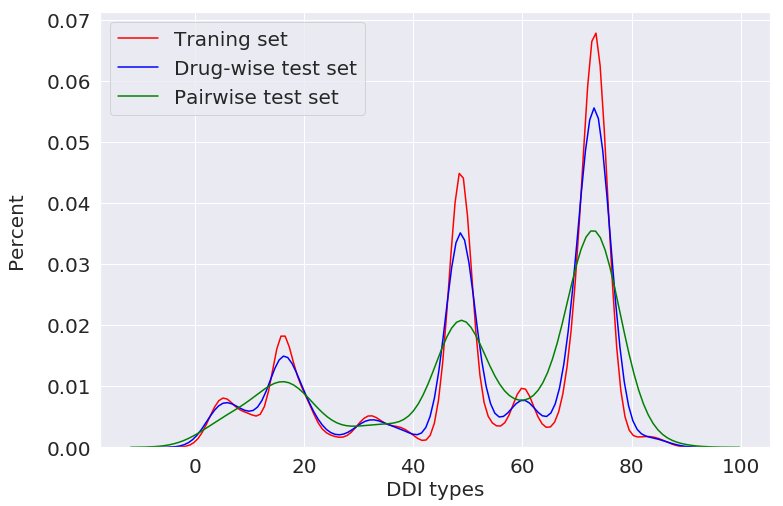

In [22]:
sns.set(rc={'figure.figsize':(12,8),'legend.fontsize': 20.0})
ax = sns.distplot( train_results.Label ,hist =False, norm_hist= True, color="red", label="Traning set")    
ax = sns.distplot( drugwise_results.Label, hist =False,norm_hist= True, color="blue", label="Drug-wise test set")
ax = sns.distplot( pairwise_results.Label, hist =False,norm_hist= True, color="green", label="Pairwise test set")

ax.set_ylabel("Percent",fontsize=20)
ax.set_xlabel("DDI types",fontsize=20)
ax.yaxis.labelpad = 20
ax.tick_params(labelsize=20)
ax.figure.savefig("db4_percent_test_mean_distribution.png")

In [23]:
dist = distribution.pivot(index='label', columns='fold', values=['Traning set', 'Drug-wise test set', 'Pairwise test set']) 

In [24]:
dist.to_csv('../results/db4_distribution_train_test.csv')